In [5]:

from datetime import datetime
import time

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn import metrics
from sklearn.preprocessing import RobustScaler

import autosklearn.classification

import matplotlib.pyplot as plt


In [6]:
df = pd.read_csv('../data/ordens_case_dnc_.csv', index_col='id')


In [7]:
df.head(2)

,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso
id,,,,,,,,,,
0,107.78,2022-02-25 20:46:25+00:00,2022-03-02 00:00:00,2022-02-28 20:35:20,2022-03-02 18:03:33,2,1,25,1,23.8
1,7.47,2022-02-23 20:34:59+00:00,2022-02-24 00:00:00,2022-02-24 09:56:23,2022-02-24 15:52:40,2,1,16,4,536.0


In [8]:
df['order_date'] = df['order_date'].str[:-6]

In [9]:
df.head(2)


,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso
id,,,,,,,,,,
0,107.78,2022-02-25 20:46:25,2022-03-02 00:00:00,2022-02-28 20:35:20,2022-03-02 18:03:33,2,1,25,1,23.8
1,7.47,2022-02-23 20:34:59,2022-02-24 00:00:00,2022-02-24 09:56:23,2022-02-24 15:52:40,2,1,16,4,536.0


In [10]:
def getTimeSeconds(x):
    d = datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    return int(time.mktime(d.timetuple()))


df['order_date'] = df['order_date'].apply(getTimeSeconds)
df['due_date'] = df['due_date'].apply(getTimeSeconds)
df['opt_date'] = df['opt_date'].apply(getTimeSeconds)
df['delivery_date'] = df['delivery_date'].apply(getTimeSeconds)


In [11]:
df['elapsed_time'] = df['delivery_date'] - df['opt_date']


In [12]:
df.head(3)


,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,elapsed_time
id,,,,,,,,,,,
0,107.78,1645832785,1646190000,1646091320,1646255013,2,1,25,1,23.8,163693
1,7.47,1645659299,1645671600,1645707383,1645728760,2,1,16,4,536.0,21377
2,5.98,1645659319,1645671600,1645658978,1645754138,2,1,88,1,202.0,95160


In [13]:
df['outcome'] = 0
df['outcome'].iloc[df['due_date'] <= df['delivery_date']] = 1


/tmp/ipykernel_3272/1026693437.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outcome'].iloc[df['due_date'] <= df['delivery_date']] = 1


In [15]:
df['outcome'].value_counts()

1    1244
0     551
Name: outcome, dtype: int64

In [54]:
df.head(3)

,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,elapsed_time,outcome
id,,,,,,,,,,,,
0,107.78,1645832785,1646190000,1646091320,1646255013,2,1,25,1,23.8,163693,1
1,7.47,1645659299,1645671600,1645707383,1645728760,2,1,16,4,536.0,21377,1
2,5.98,1645659319,1645671600,1645658978,1645754138,2,1,88,1,202.0,95160,1


In [55]:
df["cidade_origem_id"] = df["cidade_origem_id"].astype("category")
df["regiao_origem_id"] = df["regiao_origem_id"].astype("category")
df["cidade_destino_id"] = df["cidade_destino_id"].astype("category")
df["regiao_destino_id"] = df["regiao_destino_id"].astype("category")


In [56]:
df.dtypes

price                 float64
order_date              int64
due_date                int64
opt_date                int64
delivery_date           int64
cidade_origem_id     category
regiao_origem_id     category
cidade_destino_id    category
regiao_destino_id    category
peso                  float64
elapsed_time            int64
outcome                 int64
dtype: object

<AxesSubplot:ylabel='Frequency'>

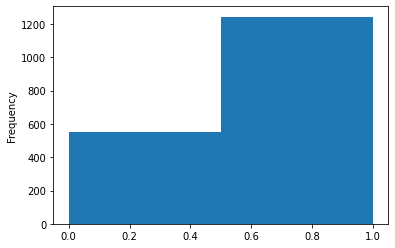

In [16]:
df['outcome'].plot.hist(bins=2)


In [17]:
def trataDados(df_dados, target):
    # Dummificação
    dfCat = pd.get_dummies(df_dados.select_dtypes(include=['category']), columns=[
        'cidade_origem_id', 'regiao_origem_id', 'cidade_destino_id', 'regiao_destino_id']).copy()

    df_dados.drop(columns=['cidade_origem_id', 'regiao_origem_id', 'cidade_destino_id', 'regiao_destino_id'], inplace = True)
    df_dados = df_dados.join(dfCat)

    # Normalização dos dados (verificar com outros normalizadores)
    dfNum = pd.DataFrame()
    dfNum[['price', 'order_date', 'due_date', 'opt_date', 'delivery_date', 'peso', 'elapsed_time']] = RobustScaler(
    ).fit_transform(df_dados[['price', 'order_date', 'due_date', 'opt_date', 'delivery_date', 'peso', 'elapsed_time']]).copy()

    df_dados.drop(columns=['price', 'order_date', 'due_date', 'opt_date',
                  'delivery_date', 'peso', 'elapsed_time'], inplace=True)
    df_dados = df_dados.join(dfNum)

    return df_dados, target


In [59]:
X = df.drop(['outcome'], axis=1)
y = df['outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train = pd.DataFrame(X_train, columns=X_train.columns)
y_train = pd.Series(y_train)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x

X_train, y_train = trataDados(X_train, y_train)
X_val, y_val = trataDados(X_val, y_val)
X_test, y_test = trataDados(X_test, y_test)


In [60]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=30,
    per_run_time_limit=10)


In [61]:
automl.fit(X_train, y_train)


/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


AutoSklearnClassifier(per_run_time_limit=10, time_left_for_this_task=30)

In [62]:
pred = automl.predict(X_test)


F1 Score: 64.67%
Accuracy Score: 67.41%
Precision Score: 80.28%
Recall Score: 69.51%


/home/felipe/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


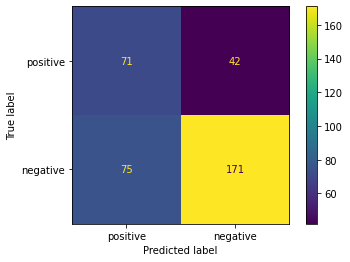

/home/felipe/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


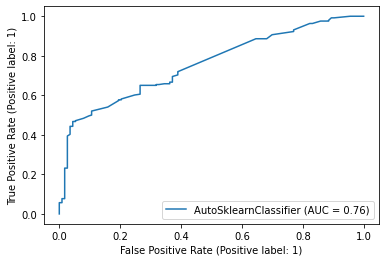

In [63]:
predictAutoML = automl.predict(X_val)

f1 = round(f1_score(y_val, predictAutoML, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, predictAutoML)*100, 2)
precision = round(precision_score(y_val, predictAutoML)*100, 2)
recall = round(recall_score(y_val, predictAutoML)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(automl, X_val, y_val, display_labels=[
                      "positive", "negative"], values_format="d")
plt.grid(False)
plt.show()

metrics.plot_roc_curve(automl, X_val, y_val)
plt.show()


In [64]:
pd.DataFrame(automl.show_models()).transpose()

,model_id,rank,cost,ensemble_weight,data_preprocessor,balancing,feature_preprocessor,classifier,sklearn_classifier
2,2,1,0.27809,0.14,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=6, random..."
4,4,2,0.300562,0.14,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"LinearSVC(C=17045.7732372673, dual=False, inte..."
8,8,3,0.300562,0.32,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_depth=6, random_st..."
6,6,4,0.303371,0.3,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"LinearDiscriminantAnalysis(shrinkage=0.5, solv..."
3,3,5,0.317416,0.1,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(criterion='entropy', m..."
